<a href="https://colab.research.google.com/github/Mondardo/cycleGAN/blob/main/cycleGAN_jaguar_to_lion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Deep learning performance: K80 < P4 < T4 < P100
gpu = !nvidia-smi -L
print('Not using GPU' if 'failed' in gpu[0] else gpu[0].split(' (')[0])

GPU 0: Tesla P100-PCIE-16GB


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize

AUTOTUNE = tf.data.AUTOTUNE

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Frechet Inception Distance (FID):



In [ ]:
# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return np.asarray(images_list)
 
# calculate frechet inception distance
def calculate_fid(model, images1, test_images):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(test_images)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = np.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if np.iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid
 
# prepare the inception v3 model
model_inceptionV3 = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
# load cifar10 images

In [ ]:
BUFFER_SIZE = 1500
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

def preprocess_image_train(image):
  image = random_jitter(image)
  image = normalize(image)
  return image

def preprocess_image_test(image):
  image = normalize(image)
  return image

Load and preprocess lion images:

In [ ]:
path = '/content/gdrive/My Drive/Colab Notebooks/lion/'

img_size = 256

train_images = []

images = os.listdir(path)[0:BUFFER_SIZE]

for i in images: # all train cat images
    if os.path.isfile(path + i): # check image in file
        image = Image.open(path + i)
        image = image.resize((img_size,img_size), Image.ANTIALIAS) # resizing
        image = np.asarray(image) # bit format
        if (image.ndim == 3) and (image.shape[2] == 3):
          train_images.append(image)

np.shape(train_images)
train_images = np.array(train_images)

train_images = train_images.astype('float32')

In [ ]:
train_lion, test_lion = train_test_split(train_images, test_size=0.1)
print(f'Lions Train set shape: {train_lion.shape}')
print(f'Lions Test set shape:  {test_lion.shape}')

Lions Train set shape: (1347, 256, 256, 3)
Lions Test set shape:  (150, 256, 256, 3)


In [ ]:
train_lion = tf.data.Dataset.from_tensor_slices(train_lion).prefetch(1)
train_lion = train_lion.cache().map(preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_lion = tf.data.Dataset.from_tensor_slices(test_lion).prefetch(1)
test_lion = test_lion.cache().map(preprocess_image_test, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
sample_lion = np.zeros(len(test_lion)*256*256*3).reshape(len(test_lion),256,256,3)

n = 0
for i in iter(test_lion):
  sample_lion[n,:,:,:] = i
  n = n + 1

Load and preprocess jaguar images:

In [ ]:
path = '/content/gdrive/My Drive/Colab Notebooks/jaguar/'

img_size = 256

train_images = []

images = os.listdir(path)[0:BUFFER_SIZE]

for i in images: # all train cat images
    if os.path.isfile(path + i): # check image in file
        image = Image.open(path + i)
        image = image.resize((img_size,img_size), Image.ANTIALIAS) # resizing
        image = np.asarray(image) # bit format
        # print(type(image))
        if (image.ndim == 3) and (image.shape[2] == 3):
          train_images.append(image)

np.shape(train_images)
train_images = np.array(train_images)

train_images = train_images.astype('float32')

In [ ]:
train_jaguar, test_jaguar = train_test_split(train_images, test_size=0.1)
print(f'Jaguar Train set shape: {train_jaguar.shape}')
print(f'Jaguar Test set shape:  {test_jaguar.shape}')

Jaguar Train set shape: (1216, 256, 256, 3)
Jaguar Test set shape:  (136, 256, 256, 3)


In [ ]:
train_jaguar = tf.data.Dataset.from_tensor_slices(train_jaguar).prefetch(1)
train_jaguar = train_jaguar.cache().map(preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_jaguar = tf.data.Dataset.from_tensor_slices(test_jaguar).prefetch(1)
test_jaguar = test_jaguar.cache().map(preprocess_image_test, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
sample_jaguar = np.zeros(len(test_jaguar)*256*256*3).reshape(len(test_jaguar),256,256,3)

n = 0
for i in iter(test_jaguar):
  sample_jaguar[n,:,:,:] = i
  n = n + 1

Instance normalization:

In [ ]:
class InstanceNormalization(tf.keras.layers.Layer):
  """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset

Downsample layers:

In [ ]:
#downsample with instance normalization
def downsample(filters, size, apply_norm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_norm:
    result.add(InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

Upsample layers:

In [ ]:
# upsample with instance normalization
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

Generator net:

In [ ]:
def unet_generator(output_channels):
  """Modified u-net generator model (https://arxiv.org/abs/1611.07004)"""

  down_stack = [
      downsample(64, 4, apply_norm=False),  # (bs, 128, 128, 64)
      downsample(128, 4),  # (bs, 64, 64, 128)
      downsample(256, 4),  # (bs, 32, 32, 256)
      downsample(512, 4),  # (bs, 16, 16, 512)
      downsample(512, 4),  # (bs, 8, 8, 512)
      downsample(512, 4),  # (bs, 4, 4, 512)
      downsample(512, 4),  # (bs, 2, 2, 512)
      downsample(512, 4),  # (bs, 1, 1, 512)
  ]

  up_stack = [
      upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
      upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
      upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
      upsample(512, 4),  # (bs, 16, 16, 1024)
      upsample(256, 4),  # (bs, 32, 32, 512)
      upsample(128, 4),  # (bs, 64, 64, 256)
      upsample(64, 4),  # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 4, strides=2,
      padding='same', kernel_initializer=initializer,
      activation='tanh')  # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None, None, 3])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Discriminator net:

In [ ]:
def discriminator(target=True):
  """PatchGan discriminator model (https://arxiv.org/abs/1611.07004)."""

  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
  x = inp

  if target:
    tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(
      512, 4, strides=1, kernel_initializer=initializer,
      use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

  norm1 = InstanceNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(
      1, 4, strides=1,
      kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

  if target:
    return tf.keras.Model(inputs=[inp, tar], outputs=last)
  else:
    return tf.keras.Model(inputs=inp, outputs=last)

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = unet_generator(OUTPUT_CHANNELS)
generator_f = unet_generator(OUTPUT_CHANNELS)

discriminator_x = discriminator(target=False)
discriminator_y = discriminator(target=False)

Losses:

In [ ]:
# cycle loss and identity loss hyperparameter:
LAMBDA = 10

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
  # real: output do discriminador quando recebe uma imagem real
  # generated: output do discriminador quando recebe uma imagem gerada pelo gerador (imagem fake)
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image)) # reduce_mean eh o mean simplesmente tipo np.mean
  
  return LAMBDA * loss1

def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Optimizers:

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

Checkpoints:

In [ ]:
checkpoint_path = "/content/gdrive/My Drive/Colab Notebooks/lionjaguar_checkpoints2"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [ ]:
EPOCHS = 90

Generate images, plot images and calculate FID:

In [ ]:
def generate_images(model, test_input, input_horses_test, images2, fids, epoch):
  for j in range(test_input.shape[0]):
    prediction = model(test_input[j:j+1,:,:,:])
    
    plt.figure(figsize=(12, 12))

    display_list = [test_input[j], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
      plt.subplot(1, 2, i+1)
      plt.title(title[i])
      # getting the pixel values between [0, 1] to plot it.
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
    plt.savefig('/content/gdrive/My Drive/Colab Notebooks/lionjaguar2/image_{:04d}_at_epoch_{:04d}.png'.format(j+1, epoch+1))
    plt.show()
    plt.close()

  images1 = model(input_horses_test).numpy()
  shuffle(images1)
  ## convert integer to floating point values
  images1 = images1.astype('float32')
  images2 = images2.astype('float32')
  # resize images
  images1 = scale_images(images1, (299,299,3))
  images2 = scale_images(images2, (299,299,3))
  ## pre-process images
  images1 = preprocess_input(images1)
  images2 = preprocess_input(images2)
  # calculate fid
  # if (epoch + 5) % 5 == 0:
  fid = calculate_fid(model_inceptionV3, images1, images2)
  fids.append(fid)
  return fids

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))
  return total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss

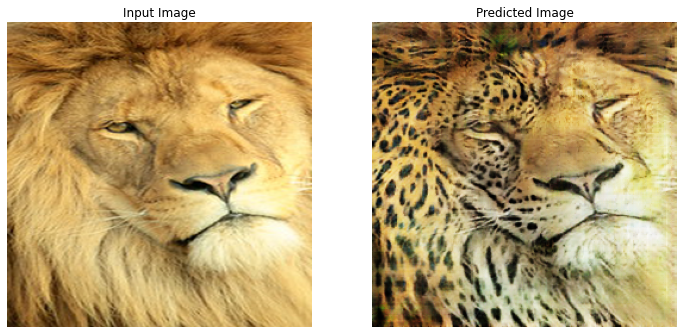

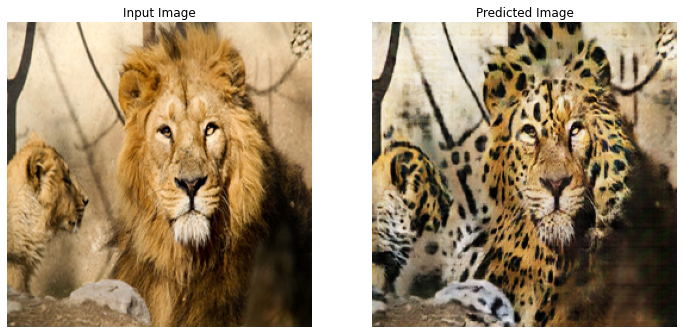

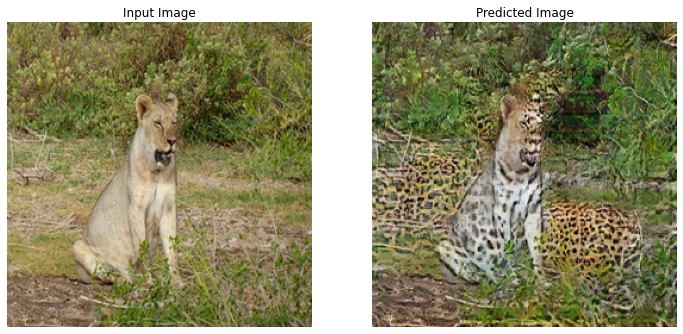

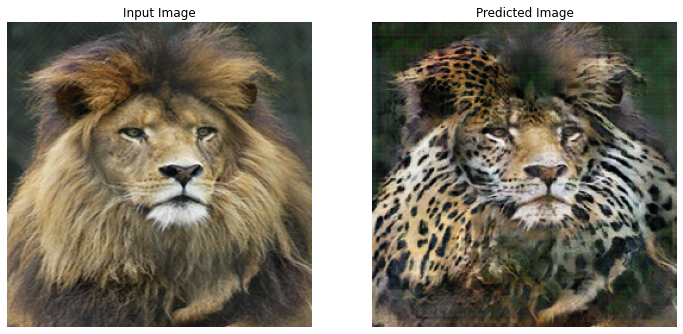

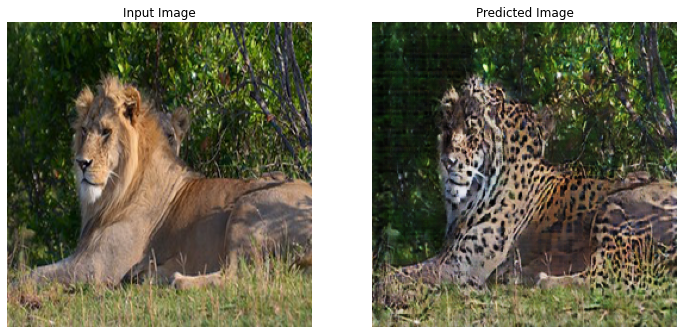

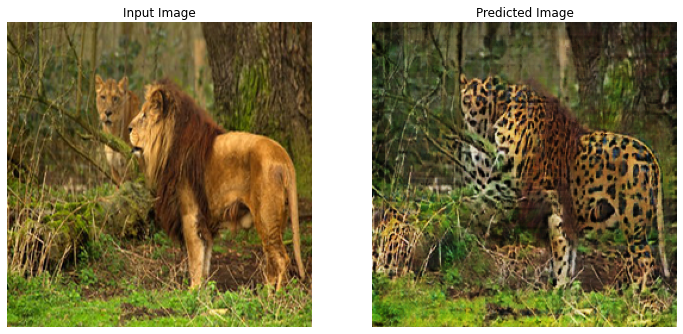

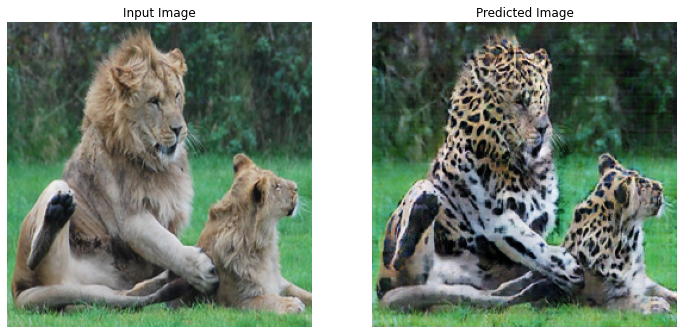

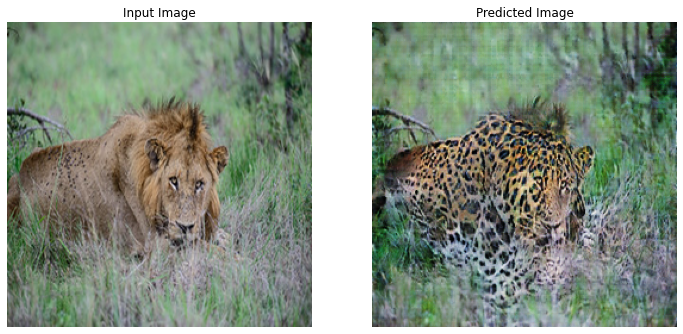

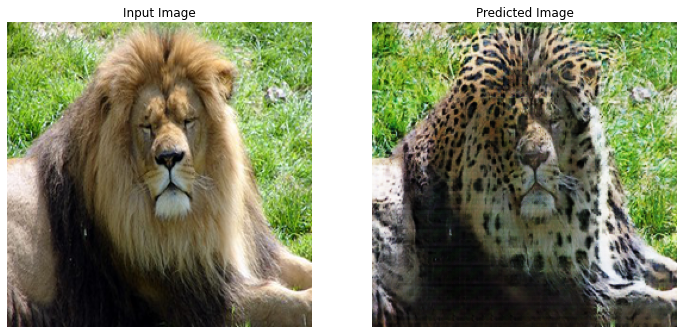

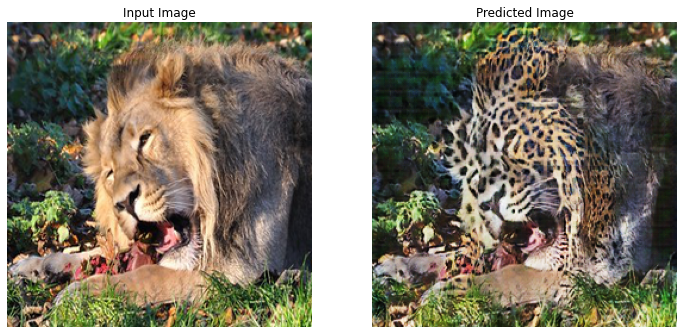

Time taken for epoch 90 is 295.31272625923157 sec



In [ ]:
total_gen_g_losses = []
total_gen_f_losses = []
disc_x_losses = []
disc_y_losses = []
fids = []

for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_lion, train_jaguar)):
    total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss = train_step(image_x, image_y)
    total_gen_g_losses.append(total_gen_g_loss)
    total_gen_f_losses.append(total_gen_f_loss)
    disc_x_losses.append(disc_x_loss)
    disc_y_losses.append(disc_y_loss)

    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image so that the progress of the model
  # is clearly visible.
  fids = generate_images(generator_g, sample_lion[0:10,:,:,:], sample_lion, sample_jaguar, fids, epoch)

  if (epoch + 1) % 20 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))
  
  total_gen_g_losses_new = []
  for i in total_gen_g_losses:
    total_gen_g_losses_new.append(i.numpy())

  total_gen_f_losses_new = []
  for i in total_gen_f_losses:
    total_gen_f_losses_new.append(i.numpy())
    
  disc_x_losses_new = []
  for i in disc_x_losses:
    disc_x_losses_new.append(i.numpy())

  disc_y_losses_new = []
  for i in disc_y_losses:
    disc_y_losses_new.append(i.numpy())

  np.savetxt("/content/gdrive/My Drive/Colab Notebooks/lionjaguar2/gen_g_losses.csv", total_gen_g_losses_new)
  np.savetxt("/content/gdrive/My Drive/Colab Notebooks/lionjaguar2/gen_f_losses.csv", total_gen_f_losses_new)
  np.savetxt("/content/gdrive/My Drive/Colab Notebooks/lionjaguar2/disc_x_losses.csv", disc_x_losses_new)
  np.savetxt("/content/gdrive/My Drive/Colab Notebooks/lionjaguar2/disc_y_losses.csv", disc_y_losses_new)
  np.savetxt("/content/gdrive/My Drive/Colab Notebooks/lionjaguar2/fids.csv", fids)